<h1>DLPy RNN Text Classification Example</h1>

The following SAS DLPy example performs a textual sentiment analysis task by creating a simple RNN text classification network. The task is to process textual consumer reviews and classify the consumer sentiment as, `negative`, `neutral`, or `positive`. 

The example uses toy training and test data sets that contain text input. The toy data sets are included in the example code. 

The example assumes that you begin with an active CAS server session as well as pandas, NumPy, and DLPy libraries.

The text classification example also requires a word embedding file used to generate word vectors. Open source pre-trained word embedding files from providers such as Glove and Word2Vec will suffice for example purposes.

<h3>Start and Configure CAS Session</h3>


SAS DLPy requires a running SAS CAS server and Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to CAS. 

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.


After preparing the environment for data loading, import Python libraries for the SWAT message handler class, the pandas data analysis library, and the NumPy scientific computing library. 


In [1]:
# Configure CAS session for Analytics
# Import SWAT
import swat
conn = swat.CAS(cashost, casport)

# Exception handler for reading StringIO text data into memory
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
    
# SWAT data message handler
import swat.cas.datamsghandlers as dmh

# Python utility libraries
import pandas as pd
import numpy as np

<h3>Import DLPy Package and Classes</h3>

Now import the DLPy libraries that will be used for the sentiment analysis text classification task in the following code. 

First, import the `Sequential` class for network models. Then import the `TextParms` class from DLPy model, the `Bidirectional` class from DLPy blocks, and the `TextClassifications` class from DLPy applications. 

In [2]:
# Import DLPy
import dlpy
from dlpy import Sequential
from dlpy import *
from dlpy.model import TextParms
from dlpy.blocks import Bidirectional
from dlpy.applications import TextClassification

After loading and DLPy, use the pandas `read_csv()` function to load the pre-trained word embeddings file `word_embeddings.txt` into a Python dataframe.  Then, use the `upload_frame()` function to upload the Python in-memory dataframe into a CAS table `word_embeddings` on the CAS server.

In [4]:
# load word embeddings: vector representations of words
# this example uses pre-trained word embeddings 
embeddings = pd.read_csv('/disk/linux/dlpy/word_embeddings.txt', skipinitialspace=True, index_col=False, delimiter='\t')
conn.upload_frame(embeddings, casout=dict(name='word_embeddings', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table WORD_EMBEDDINGS in caslib CASUSER(etfcan).
NOTE: The table WORD_EMBEDDINGS has been created in caslib CASUSER(etfcan) from binary data uploaded to Cloud Analytic Services.


CASTable('WORD_EMBEDDINGS', caslib='CASUSER(etfcan)')

<h3>Create Training Data Set and Load as CAS Table</h3>

Now create the toy data set for the sentiment analysis example. The text input contains a brief review, a sentiment classification (`negative`, `neutral`, `positive`), and an integer ranking of 1-5 review "stars" indicating degree of satisfaction.

Use data handler and the `addtable()` function to upload recently created sentiment_data into a CAS table `SENTIMENT_DATA`.

In [5]:
# create a toy dataset that has text input 
# as an example we will use sentiment analysis where the input is the review itself

sentiment_data = StringIO('''review,sentiment,stars
 "The line was too long and the food was just average. Not coming back again.","negative", 2
 "The desserts are to die for! You should definitely try the banana pudding!","positive", 5
 "My friends like this place so much but I don't understand what is so great. Just fine I guess.","neutral", 3 
 "I love the feeling in this place. From the decorations to the friendliness, it makes me feel happy!","positive", 5
 "I can't see any reason to go to this place. You pay top dollar for cold food","negative", 1
 "This is my favorite place to celebrate birthdays! They always have a cake! Yum!","positive", 4
 "Regular stuff. Salad, burger, hot dog. Nothing extraordinary.","neutral", 3
 "Wow! This was the best burger I had for years. You won't believe how juicy it was!","positive", 5
 "Their side salad is huge! Good value for the money.","positive", 4
 "I am not so crazy about the cold food in here","negative", 2
 "This place is really really expensive!!","negative", 1
 "You should definitely try the desserts","positive", 5
 "This place is just fine. Nothing more nothing less.","neutral", 3
 "Great food, wonderful atmosphere","positive", 5
 "I love this place! Such a nice restaurant to go to in weekends","positive", 5 
 "Worst restaurant ever!","negative", 2
 "Don\'t ever waste your time and money. Such a disaster!","negative", 1
 ''')
handler = dmh.CSV(sentiment_data, skipinitialspace=True)
conn.addtable(table='sentiment_data', replace=True, **handler.args.addtable)

[caslib]

 'CASUSER(etfcan)'

[tableName]

 'SENTIMENT_DATA'

[casTable]

 CASTable('SENTIMENT_DATA', caslib='CASUSER(etfcan)')

+ Elapsed: 0.00558s, user: 0.000193s, sys: 0.000474s, mem: 0.733mb

<h3>Create Test Data Set and Load as CAS Table</h3>

Now use additional text data (contained in the following example code) to create a test data partition. Use `addtable()` to upload `sentiment_test` to the CAS server as CAS table `SENTIMENT_TEST`.  

In [6]:
# create a sample test data as well
sentiment_test = StringIO('''review,sentiment,stars
 "I am not a fan of cold food especially if it is expensive...","negative", 2
 "Wow! I love this place. One of the best places to go for desserts! ","positive", 5
 "Regular stuff. Nothing extraordinary.","neutral", 3
 ''')
handler = dmh.CSV(sentiment_test, skipinitialspace=True)
conn.addtable(table='sentiment_test', replace=True, **handler.args.addtable)

[caslib]

 'CASUSER(etfcan)'

[tableName]

 'SENTIMENT_TEST'

[casTable]

 CASTable('SENTIMENT_TEST', caslib='CASUSER(etfcan)')

+ Elapsed: 0.00301s, sys: 0.000638s, mem: 0.732mb

<h3>Create and Define Simple RNN Model to Classify Reviews</h3>


The environment, tools, and data are defined. Now create a simple RNN model and define its architecture. Use DLPy to create a text classification model named `easy_model`:

In [7]:
# create a simple RNN model for classifying reviews
easy_model = TextClassification(conn)

NOTE: Output layer added.
NOTE: Model compiled successfully.


Use the `plot_network()` function to visualize the DAG for the text classification network created with DLPy.

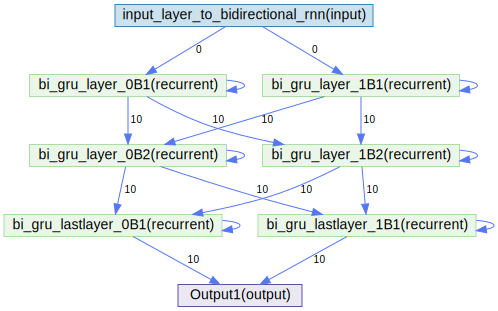

In [8]:
# visualize the model
easy_model.plot_network()

<h3>Create a Deeper RNN Model to Classify Reviews</h3>


It's easy enough to create a second, more complex RNN network model to classify reviews. The code that follows creates an RNN text classification model named `model` that has 20 neurons in each layer and 5 bi-directional blocks:

In [9]:
# Create more complex model named 'model' by increasing 
# the number of neurons in each layer to 20, and by 
# increasing the number of bi-directional blocks to 5.

model = TextClassification(conn, neurons=20, n_blocks=5)

NOTE: Output layer added.
NOTE: Model compiled successfully.


Use the `plot_network()` function to visualize the DAG for the larger, more complex text classification network created with DLPy.

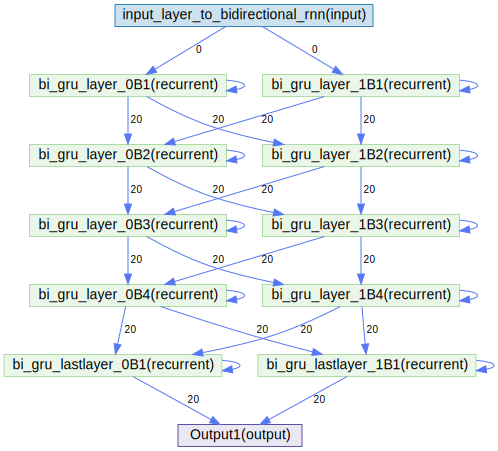

In [10]:
model.plot_network()

<h3> Train the Simple RNN Model to Classify Reviews</h3>


Use `fit()` to train the simple RNN model `easy_model` to use the text data in `review` to predict the nominal target `sentiment`. Use the word embeddings file `WORD_EMBEDDINGS` that was previously uploaded to CAS. Use a mini-batch size of 1, perform a max of 10 epochs, use a learning rate of 0.01, and use basic log reporting.

In [11]:
# train the sentiment analysis model
easy_model.fit(data='sentiment_data', inputs='review', texts='review', target='sentiment', nominals='sentiment',
               text_parms=TextParms(init_input_embeddings='word_embeddings'),
               mini_batch_size=1, 
               max_epochs=10, 
               lr=0.01, 
               log_level=2)

NOTE: Training from scratch.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 43923.
NOTE:  The approximate memory cost is 22.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.51 (s).
NOTE:  The total number of threads on each worker is 72.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 72.
NOTE:  Target variable: sentiment
NOTE:  Number of levels for the target variable:      3
NOTE:  Levels for the target variable:
NOTE:  Level      0: negative
NOTE:  Level      1: neutral 
NOTE:  Level      2: positive
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          0.01           1.153     0.6471     0.02
NOTE:  1          0.01           1.137     0.7059     0.02
NOTE:  2          0.01           1.056     0.470

,Descr,Value
0,Model Name,text_classifier
1,Model Type,Recurrent Neural Network
2,Number of Layers,12
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,10
9,Number of Weight Parameters,43320


The resuling trained RNN network has 1 input layer, 5 bi-directional blocks (2 recurrent layer each), and 1 output layer. The model network has 43,923 parameters.

<h3> Use Trained Simple RNN Model to Score Test Data</h3>


Use `evaluate()` and `word_embeddings` to score the test data `sentiment_test` using the trained sentiment analysis model `easy_model`. 

Remember that the test data contains only 3 observations.

In [12]:
# score the test data using the trained RNN model 'easy_model'
# inference will predict the sentiment of the reviews in the test table
easy_model.evaluate(data='sentiment_test',
                    top_probs=2, 
                    text_parms=TextParms(init_input_embeddings='word_embeddings'))

NOTE: Due to data distribution, miniBatchSize has been limited to 3.


[ScoreInfo]

                                Descr         Value
 0        Number of Observations Read             3
 1        Number of Observations Used             3
 2        Misclassification Error (%)      66.66667
 3  Top 2 Misclassification Error (%)             0
 4                         Loss Error      1.125306

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(etfcan)  Valid_Res_K7UbAY     3       14   
 
                                             casTable  
 0  CASTable('Valid_Res_K7UbAY', caslib='CASUSER(e...  

+ Elapsed: 1.47s, user: 3.94s, sys: 2.92s, mem: 585mb